# Imports and Load Data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Load data from .csv
data = pd.read_csv('EPL_match_data.csv')
data.head(5)

,game_ID,home_team,away_team,home_goals,away_goals,possession_home,possession_away,shots_on_target_home,shots_on_target_away,shots_home,...,corners_home,corners_away,offsides_home,offsides_away,yellow_cards_home,yellow_cards_away,fouls_conceded_home,fouls_conceded_away,red_cards_home,red_cards_away
0,93691,Arsenal,Everton,2,1,69.1,30.9,5,2,26,...,8,1,1,4,4,3,8,11,0,0
1,93692,Brentford,Newcastle,2,4,53.8,46.2,5,7,10,...,3,0,2,1,4,4,15,11,0,0
2,93693,Brighton,Man Utd,0,2,54.8,45.2,3,4,17,...,7,5,0,1,1,3,10,9,0,0
3,93694,Burnley,Nott'm Forest,1,2,72.6,27.4,3,6,20,...,4,3,0,2,1,0,11,5,0,0
4,93695,Chelsea,Bournemouth,2,1,61.4,38.6,6,5,16,...,6,5,0,1,2,3,5,9,0,0


# Clean Data

Create Target Variable

In [2]:
# Target Variable (outcome)
# -1: Away Team Win 
#  0: Draw
#  1: Home Team Win 

# Create an array to store target variable
num_games = len(data)
outcome = np.zeros(num_games)

for i in range(num_games):

    # Get home and away score
    home_score = data['home_goals'][i]
    away_score = data['away_goals'][i]

    # Compare scores and update the outcome array
    if home_score > away_score:
        outcome[i] = 1

    elif home_score == away_score:
        outcome[i] = 0

    else:
        outcome[i] = -1

# Add columns to df
data['outcome'] = outcome


Remove Useless Columns

In [3]:
# Columns to drop
columns_to_remove = ['game_ID', 'home_team', 'away_team', 'home_goals', 'away_goals']

# Drop the columns
data.drop(columns_to_remove, axis=1, inplace=True)

Check For Missing Values

In [4]:
data.isna().sum()

possession_home         0
possession_away         0
shots_on_target_home    0
shots_on_target_away    0
shots_home              0
shots_away              0
touches_home            0
touches_away            0
passes_home             0
passes_away             0
tackles_home            0
tackles_away            0
clearances_home         0
clearances_away         0
corners_home            0
corners_away            0
offsides_home           0
offsides_away           0
yellow_cards_home       0
yellow_cards_away       0
fouls_conceded_home     0
fouls_conceded_away     0
red_cards_home          0
red_cards_away          0
outcome                 0
dtype: int64

Reduce Dimensionality

In [5]:
# Remove away team possession (Encoded in home possession 1 - possession_home)
data.drop('possession_away', axis=1, inplace=True)

# Create difference for each stat (Home/Away)
columns_to_decrease = data.drop(['possession_home', 'outcome'], axis=1).columns

for i in range(0, len(columns_to_decrease), 2):
    # Find the difference between the home and away column
    difference = data[columns_to_decrease[i]] - data[columns_to_decrease[i+1]]
    
    # Create new columns
    data[columns_to_decrease[i][:-5]] = difference

    # Drop old columns
    data.drop([columns_to_decrease[i], columns_to_decrease[i+1]], axis=1, inplace=True)

Display Cleaned Data 

In [6]:
data.head(5)

,possession_home,outcome,shots_on_target,shots,touches,passes,tackles,clearances,corners,offsides,yellow_cards,fouls_conceded,red_cards
0,69.1,1.0,3,21,366,353,-10,-22,7,-3,1,-3,0
1,53.8,-1.0,-2,-2,54,59,0,1,3,1,0,4,0
2,54.8,-1.0,-1,6,84,86,1,-4,2,-1,-2,1,0
3,72.6,-1.0,-3,8,414,412,-6,-21,1,-2,1,6,0
4,61.4,1.0,1,-6,199,213,3,2,1,-1,-1,-4,0


Analysis: The code above drops columns that are not not useful for the question at hand. These columns include team names, final goal totals, and the game id. Additionally, a target variable is create to indicate what the outcome of a match was to create a target for machine learning models to predict. Finally, the dimensionality was reduced by finding the difference between the home and away stat for all stats except possession. One of the possession columns was dropped. This is because by knowing the home possession the away possession is encoded since adding home + away = 100%. For the other stats the difference was found to indicate whether the home or away team did better in that stat. This is intuitive as when these stats are often compared to each other by seeing which team had the most of a certain stat.

# Data Visualization

Distribution of Match Outcomes

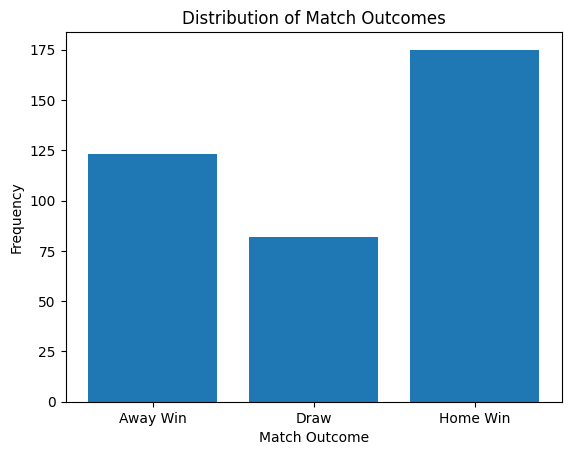

In [7]:
# Target variable classes
results = ['Away Win', 'Draw', 'Home Win']

# Counts per class
value_counts = data['outcome'].value_counts()
counts = [value_counts[-1], value_counts[0], value_counts[1]]

# Plot 
plt.bar(results, counts)
plt.title('Distribution of Match Outcomes')
plt.ylabel('Frequency')
plt.xlabel('Match Outcome')
plt.show()

Analysis: This bar graph shows that the most common outcome is that the home team wins the match. The next most common outcomes is that the away team wins, and the least common outcome is that there is a draw. None of the classes heavily outweigh the others making this dataset somewhat balanced. 
____________________________________________________________________________________________________________________________________________________________________________________________________

Violin Plots

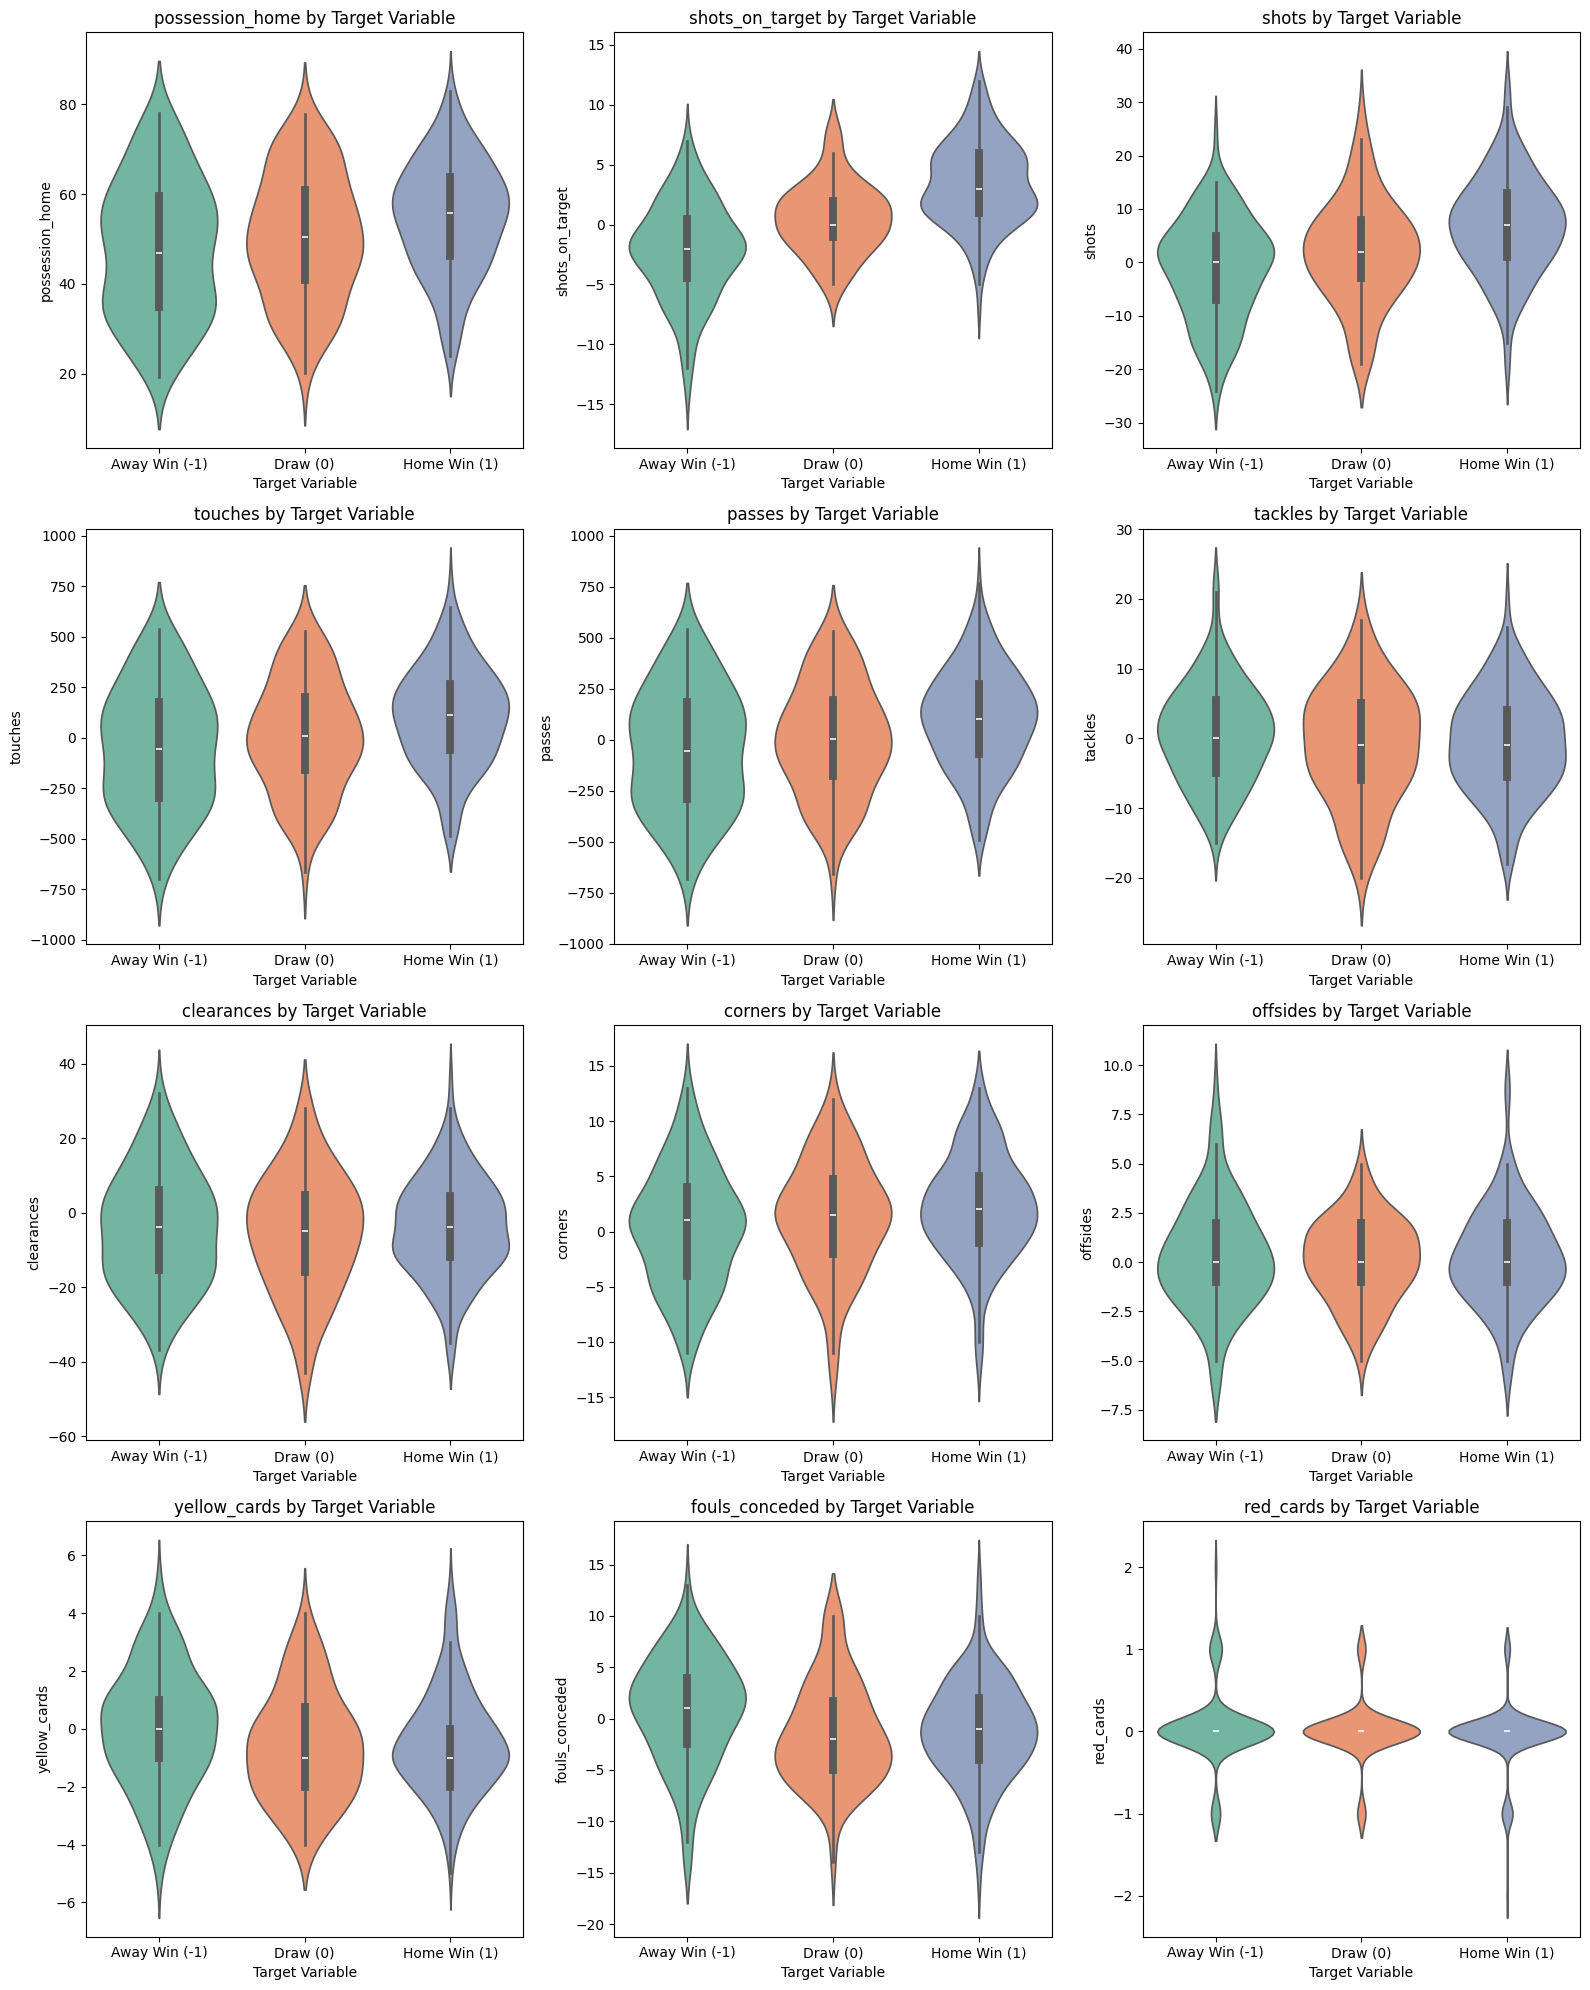

In [8]:
# Get the features
features = data.drop('outcome', axis=1).columns

# Find the number of rows needed for 3 graphs per row
num_rows = int(len(features) / 3) 

# Loop through and plot box and whisker for each feature
plt.figure(figsize=(16, num_rows * 5))

for i, feature in enumerate(features): 
    
    # Plot coordinates
    plt.subplot(num_rows, 3, i+1)
    
    # Violin Plot
    sns.violinplot(x='outcome', y=feature, data=data, hue='outcome', palette='Set2', legend=False)
    
    # Graph Labels
    plt.title(f'{feature} by Target Variable')
    plt.xlabel('Target Variable')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1, 2], labels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'])

# Show Plot
plt.tight_layout()
plt.show()

Analysis: These violin plots compare how each feature is distributed among the outcome that it belongs to. The most interesting relationships that can be seen from these graphs is the relationships shown in the shots on target and shots graphs. Remember, that the features are now the difference, home - away, so positive values indicate that the home team has a higher value in that stat compared to the away team. It is visible in the shots on target and shots graph that there is a correlation between these stats and the outcome. The team that takes the most shots on target or shots more often wins the game. This trend is visible in other stats too but not the same level as the shots on target and shots statistics. Note, the opposite trend can be seen in the negative stats. Theses "negative stats" are stats such as yellow cards, fouls conceded, and red cards. Teams do not want to increase these stats because it makes the game harder for them to win. In the yellow card graph we can see that there is a trend that if the other team has more yellow cards the team with less tends to win more often. 

____________________________________________________________________________________________________________________________________________________________

Feature Histograms

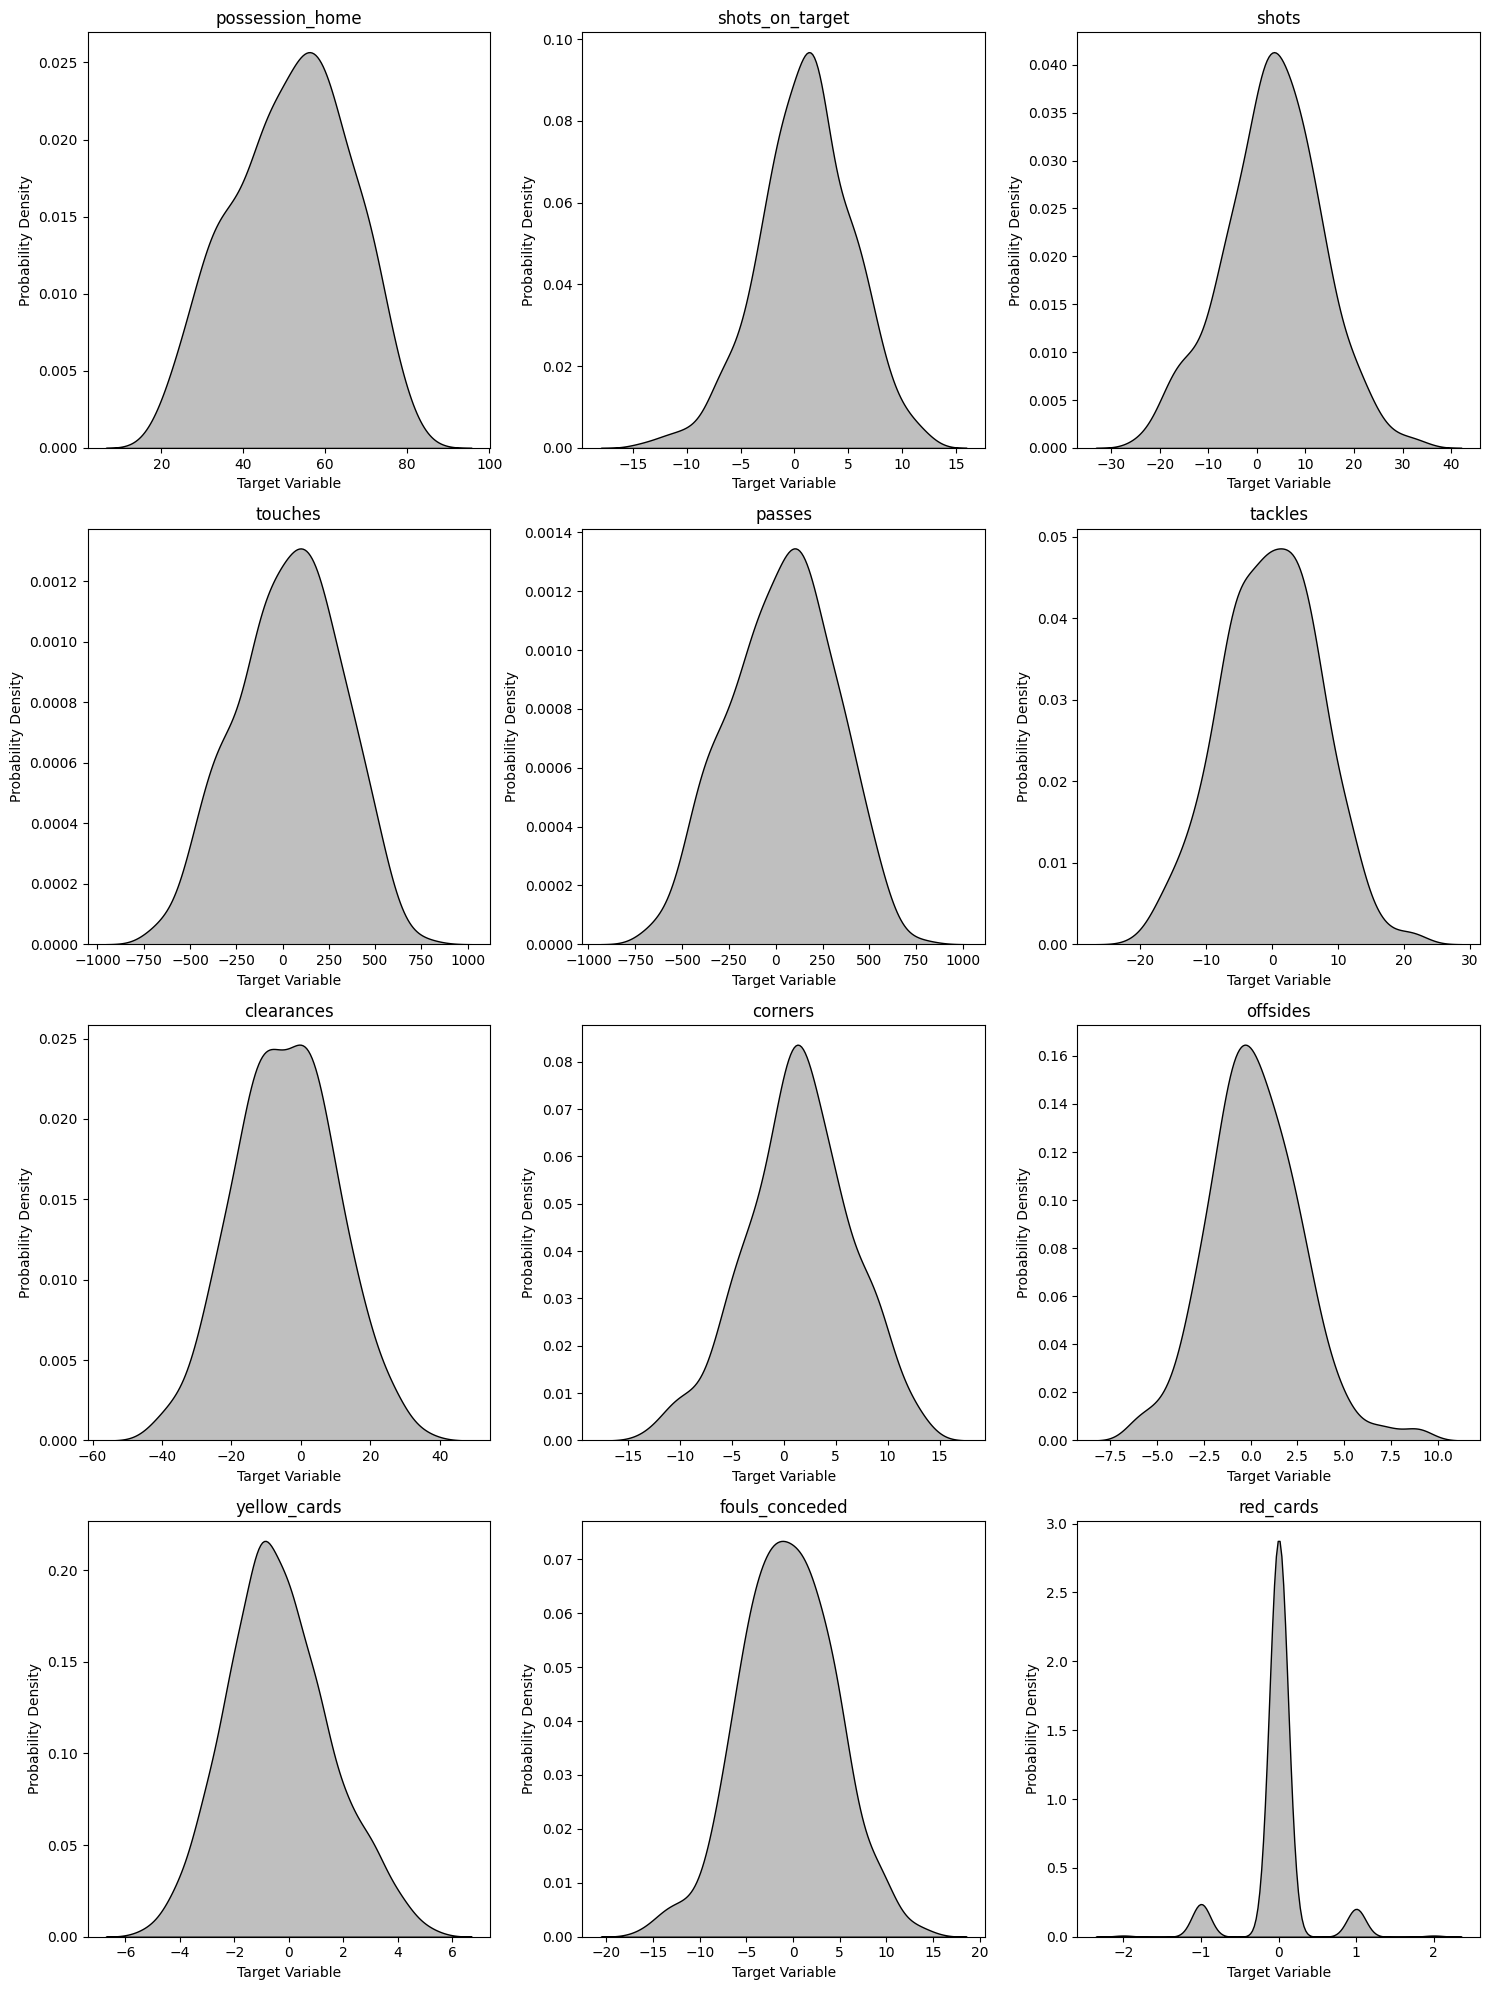

In [9]:
# Loop through and plot box and whisker for each feature
plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(features): 
    
    # Plot coordinates
    plt.subplot(num_rows, 3, i+1)
    
    # kdeplot
    sns.kdeplot(data[feature], fill=True, color='k')

    # Graph Labels
    plt.title(f'{feature}')
    plt.xlabel('Target Variable')
    plt.ylabel('Probability Density')

# Show Plot
plt.tight_layout()
plt.show()

Analysis: All of the stats appear to have a normal distribution. The one exception is red cards. It is very hard to get a red card so there is often only one if any in a game. This graph therefore appears to be trimodal. 

# Data Modeling

Split Data (80-20)

In [10]:
# Instantiate StratifiedshuffleSplit object
spliter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=10)

# Separate target variable and features
x = data.drop('outcome', axis=1)
y = data['outcome']

# Split data
for train_index, test_index in spliter.split(x, y):
    x_train = x.iloc[train_index]
    x_test = x.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

Scale Data

In [11]:
# Scale data between 0 and 1
scaler = StandardScaler()

# Fit scaler and transform train data
x_train = scaler.fit_transform(x_train)

# Transform test data
x_test = scaler.transform(x_test)

KNN GridSearch

In [19]:
# Create a base KNN classifier
base_knn = KNeighborsClassifier(n_jobs=-1)

# Search Space 
knn_search = {'n_neighbors' : [3, 5],
              'weights' : ['uniform', 'distance'],
              'p' : [1, 2]}

# Perform grid search
knn_grid_search = GridSearchCV(base_knn, knn_search, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(x_train, y_train)

# Get the parameters
print("Best parameters for KNN: ", knn_grid_search.best_params_)

Best parameters for KNN:  {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Random Forest GridSearch

In [13]:
# Create a base KNN classifier
base_rf = RandomForestClassifier(n_jobs=-1, random_state=10, )

# Search Space 
rf_search = {'n_estimators' : [100, 250, 500, 1000],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [None, 1, 2, 3, 4, 5]}

# Perform grid search
rf_grid_search = GridSearchCV(base_rf, rf_search, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(x_train, y_train)

# Get the parameters
print("Best parameters for Random Forest: ", rf_grid_search.best_params_)

Best parameters for Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 500}


Logistic Regression GridSearch

In [14]:
# Create a base logistic regression classifier
base_lr = LogisticRegression(n_jobs=-1, random_state=10)

# Search Space 
lr_search = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search
lr_grid_search = GridSearchCV(base_lr, lr_search, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(x_train, y_train)

# Get the parameters
print("Best parameters for Logistic Regression: ", lr_grid_search.best_params_)

Best parameters for Logistic Regression:  {'C': 10}


AdaBoost

In [15]:
# Create a base AdaBoost classifier
base_adaboost = AdaBoostClassifier(random_state=10, algorithm='SAMME')

# Search Space 
adaboost_search = {'n_estimators' : [50, 75, 100, 150, 250, 500, 750, 1000],
                 'learning_rate' : [0.001, 0.01, 0.1, 1, 10]}

# Perform grid search
adaboost_grid_search = GridSearchCV(base_adaboost, adaboost_search, cv=5, scoring='accuracy', n_jobs=-1)
adaboost_grid_search.fit(x_train, y_train)

# Get the parameters
print("Best parameters for AdaBoost: ", adaboost_grid_search.best_params_)

Best parameters for AdaBoost:  {'learning_rate': 1, 'n_estimators': 50}


Train Optimal Models

In [16]:
# Optimal models
knn = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', n_jobs=-1)
rf = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=4, random_state=10, n_jobs=-1)
lr = LogisticRegression(C=10, n_jobs=-1, random_state=10)
adaboost = AdaBoostClassifier(learning_rate=1, n_estimators=50, algorithm='SAMME', random_state=10)

# Train models
knn.fit(x_train, y_train)
rf.fit(x_train, y_train)
lr.fit(x_train, y_train)
adaboost.fit(x_train, y_train)

# Generate Predictions
knn_pred = knn.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)
ada_pred = adaboost.predict(x_test)

# Generate Probabilities
knn_proba = knn.predict_proba(x_test)
rf_proba = rf.predict_proba(x_test)
lr_proba = lr.predict_proba(x_test)
ada_proba = adaboost.predict_proba(x_test)


Accuracy, Precision, Recall, F1 Score

In [17]:
# Create dictionary for storing classifier information
classifiers = {
    'names' : ['KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost'],
    'pred' : [knn_pred, lr_pred, rf_pred, ada_pred],
    'proba' : [knn_proba, lr_proba, rf_proba, ada_proba]
}

columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rows = classifiers['names']

scores = []

# Find scores for all of the calssifiers
for pred in classifiers['pred']:
  acc = round(accuracy_score(y_test, pred), 4) * 100
  pre = round(precision_score(y_test, pred, average='macro'), 4) * 100
  rec = round(recall_score(y_test, pred, average='macro'), 4) * 100
  f1 =  round(f1_score(y_test, pred, average='macro'), 4) * 100
  scores.append([acc, pre, rec, f1])

# Create dataframe to display the results
df_scores = pd.DataFrame(scores, columns=columns, index=rows)
print(df_scores)

                     Accuracy  Precision  Recall  F1 Score
KNN                     56.58      51.18   50.81     50.86
Logistic Regression     63.16      56.88   55.95     55.82
Random Forest           60.53      40.81   50.29     44.96
AdaBoost                61.84      57.06   56.13     56.33


Mean ROC Curve and Mean AUC

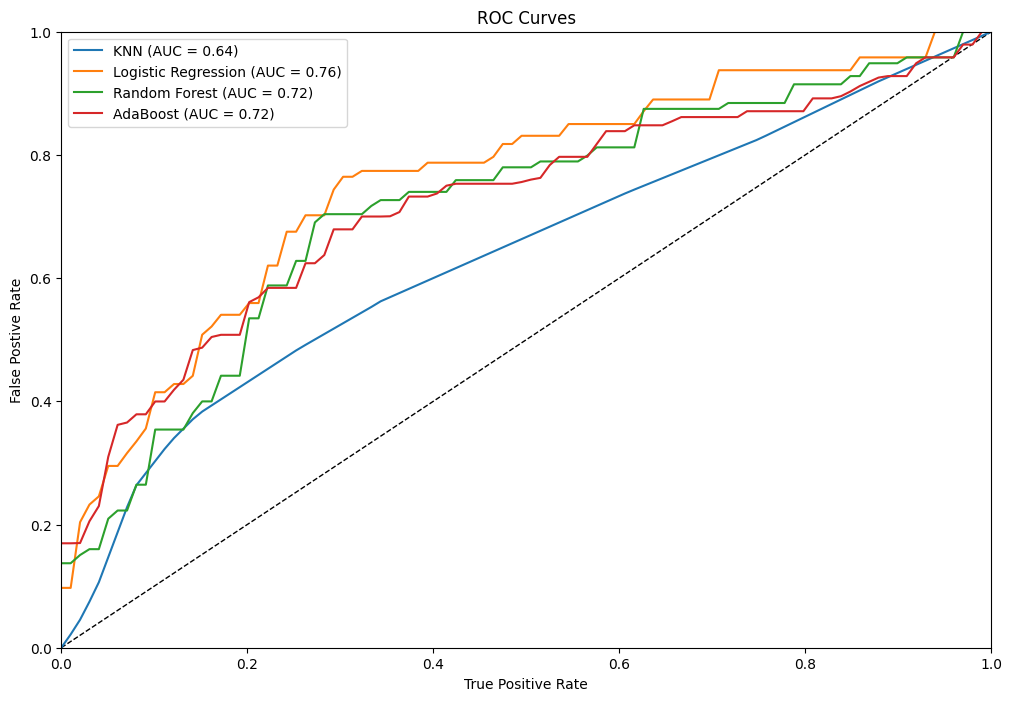

In [18]:
# Binarize the target variable
y_bin = label_binarize(y_test, classes=[-1, 0, 1])

plt.figure(figsize=(12, 8))

# Line of no discrimination
line = np.linspace(0, 1, 10)
plt.plot(line, line, color='black', linewidth=1, linestyle='--')

# Axis and tile labels
plt.xlabel('True Positive Rate')
plt.ylabel('False Postive Rate')
plt.title('ROC Curves')
plt.axis([0, 1, 0, 1])

# Assume values for fpr
fpr_mean = np.linspace(0, 1, 100)

# Loop through classifiers
for i in range(len(classifiers['names'])):
    proba = classifiers['proba'][i]
    name = classifiers['names'][i]

    mean_tpr = []

    # Loop through each class
    for i in range(3):
        # Compute ROC curve and ROC area per class
        fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i], pos_label=1)
        mean_tpr.append(np.interp(fpr_mean, fpr, tpr))

    # Calculate mean tpr and AUC
    tpr_mean = np.mean(mean_tpr, axis=0)
    auc_mean = auc(fpr_mean, tpr_mean)
           
    # Plot the mean ROC curve for the classifier
    plt.plot(fpr_mean, tpr_mean, label=f'{name} (AUC = {auc_mean:.2f})')


plt.legend()
plt.show()

Analysis: This task seems pretty hard for classical machine learning models. As shown in the mean ROC curves all of the classifiers perform better than random guessing. The mean ROC curves and mean AUC scores show that the logistic regression model performs the best for this task. A similar story is present in the accuracy, precision, recall, and F1 metrics. The logistic regression model has the highest accuracy score and second highest precision, recall, and F1 scores only slightly behind Adaboost in these metrics. As mentioned in previous analysis of the target variable distribution there is not a heavy dominance by one of the outcomes so accuracy is a reliable metrics. So, logistic regression has the highest accuracy by a > 1% margin on the next highest accuracy from Adaboost. The worst model by far was knn. This model performed much worse on all metrics compared to the other three. The two other models, Adaboost and random forest, performed similar to each other and slightly worse that logistic regression. In the end it appears that the outcome of the match is hard to predict only based on the match stats. This indicates that there are complexities to the game of soccer that these stats do not capture. Perhaps more informative stats can be discovered and replace these stats to give soccer fans a more informative view of what the outcome of a match is. 